1. Setup

In [2]:
# 1-1. Install Dependencies
!pip install torch torchvision pandas scikit-learn tqdm

  Using cached scikit_learn-1.7.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 27.6 MB/s  0:00:00 eta 0:00:01
Using cached scikit_learn-1.7.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.7 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [torchvision] [torchvision]]


In [19]:
# 1-2. import Libraries
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import ast
# from google.colab import drive
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [20]:
# 1-3. Environment Setup
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# drive.mount('/content/drive')

device: cuda


In [21]:
# 1-3. Project Paths
PROJECT_DIR = "/home/ghhur/ellin/github/deepfashion_multimodal"
IMAGE_ROOT = f"{PROJECT_DIR}/data/raw/images"
CSV_TRAIN  = f"{PROJECT_DIR}/data/processed/train.csv"
CSV_VAL    = f"{PROJECT_DIR}/data/processed/val.csv"

df = pd.read_csv(CSV_TRAIN)

print("Project Directory:", PROJECT_DIR)
print("Train CSV:", CSV_TRAIN)
print("Val CSV:", CSV_VAL)
print("Image Root:", IMAGE_ROOT)

Project Directory: /home/ghhur/ellin/github/deepfashion_multimodal
Train CSV: /home/ghhur/ellin/github/deepfashion_multimodal/data/processed/train.csv
Val CSV: /home/ghhur/ellin/github/deepfashion_multimodal/data/processed/val.csv
Image Root: /home/ghhur/ellin/github/deepfashion_multimodal/data/raw/images


In [22]:
print("이미지 파일 수:", len(os.listdir(IMAGE_ROOT)))

이미지 파일 수: 825


2. EDA

Skipped 519 files that could not be opened.


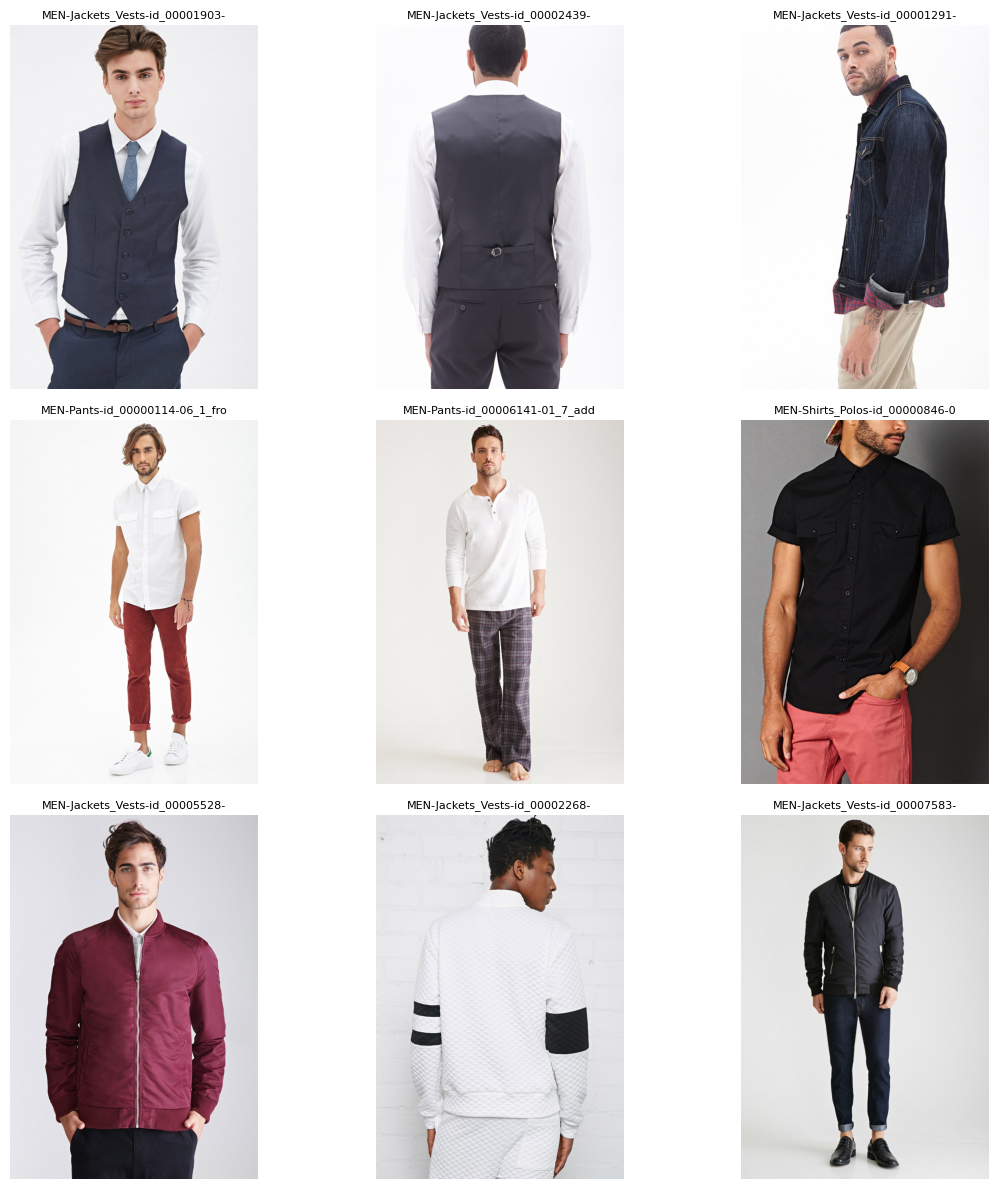

In [23]:
# 1. 데이터 샘플
def show_samples(df, num=9):
    if df.empty:
        raise ValueError("Input dataframe is empty.")

    shuffled_df = df.sample(frac=1).reset_index(drop=True)
    images_to_show = []
    skipped = 0

    for _, row in shuffled_df.iterrows():
        if len(images_to_show) >= num:
            break

        img_path = os.path.join(IMAGE_ROOT, row["image_name"])
        try:
            with Image.open(img_path) as img:
                images_to_show.append((img.convert("RGB"), row["image_name"]))
        except (FileNotFoundError, UnidentifiedImageError, OSError):
            skipped += 1
            try:
                os.remove(img_path)
            except OSError:
                pass
            continue

    if not images_to_show:
        raise RuntimeError("No valid images found to display. Please verify the dataset files.")

    cols = min(3, max(1, len(images_to_show)))
    rows = (len(images_to_show) + cols - 1) // cols
    plt.figure(figsize=(cols * 4, rows * 4))

    for idx, (img, name) in enumerate(images_to_show, start=1):
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        plt.title(name[:30], fontsize=8)
        plt.axis("off")

    if len(images_to_show) < num:
        print(f"Only {len(images_to_show)} valid images could be displayed out of {num} requested.")
    if skipped:
        print(f"Skipped {skipped} files that could not be opened.")

    plt.tight_layout()
    plt.show()

show_samples(df, num=9)

IndexError: index 0 is out of bounds for axis 0 with size 0

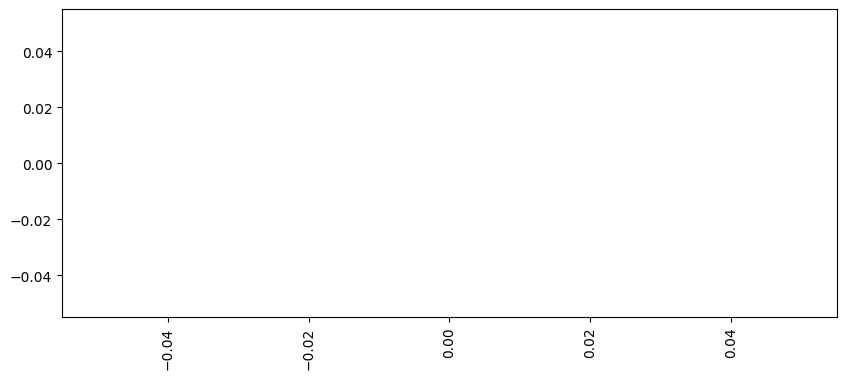

In [24]:
# 2. 라벨 분포
# shape
shape_cols = [c for c in df.columns if "shape_" in c]

df[shape_cols].sum().plot(kind="bar", figsize=(10, 4))
plt.title("Shape Attribute Distribution")
plt.xlabel("Shape Attributes")
plt.ylabel("Count")
plt.show()

In [ ]:
# fabric
fabric_cols = [c for c in df.columns if "fabric_" in c]

df[fabric_cols].sum().plot(kind="bar", figsize=(6, 4))
plt.title("Fabric Attribute Distribution")
plt.show()

In [ ]:
# pattern
pattern_cols = [c for c in df.columns if "pattern_" in c]

df[pattern_cols].sum().plot(kind="bar", figsize=(6, 4))
plt.title("Pattern Attribute Distribution")
plt.show()

In [ ]:
# 3. Attribute Correlation Heatmap
attr_cols = shape_cols + fabric_cols + pattern_cols

plt.figure(figsize=(12, 10))
sns.heatmap(df[attr_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Attribute Correlation Heatmap")
plt.show()

In [ ]:
# 4. 이미지 특성
# 해상도
def get_image_size(path):
    try:
        img = Image.open(path)
        return img.size  # (width, height)
    except:
        return None

df["img_path"] = df["image_name"].apply(lambda x: os.path.join(IMAGE_ROOT, x))
df["size"] = df["img_path"].apply(get_image_size)

df["width"]  = df["size"].apply(lambda x: x[0] if x else None)
df["height"] = df["size"].apply(lambda x: x[1] if x else None)

plt.figure(figsize=(8,5))
plt.hist(df["width"].dropna(), bins=50, alpha=0.7, label="Width")
plt.hist(df["height"].dropna(), bins=50, alpha=0.7, label="Height")
plt.legend()
plt.title("Distribution of Image Resolution")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.show()

In [ ]:
# Aspect Ratio
df["aspect_ratio"] = df["width"] / df["height"]

plt.hist(df["aspect_ratio"].dropna(), bins=50)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Count")
plt.show()

In [ ]:
# 전처리 전/후 비교
preprocess = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def show_preprocessing_example(df):
    img_name = df.sample(1)["image_name"].iloc[0]
    img_path = os.path.join(IMAGE_ROOT, img_name)

    img = Image.open(img_path).convert("RGB")
    processed = preprocess(img).permute(1,2,0).numpy()

    plt.figure(figsize=(10,4))

    # 원본
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    # 전처리 후
    plt.subplot(1,2,2)
    plt.imshow((processed * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])).clip(0,1))
    plt.title("After Preprocessing")
    plt.axis("off")

    plt.show()

show_preprocessing_example(df)

3. Dataset Definition

In [ ]:
class DeepFashionAttrDataset(Dataset):
    def __init__(self, csv_path, image_root, transform=None):
        self.df = pd.read_csv(csv_path)
        self.image_root = image_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def _parse_attr(self, attr_str):
        if isinstance(attr_str, str):
            return ast.literal_eval(attr_str)
        return attr_str

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_root, row["image_name"])

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        shape = self._parse_attr(row["shape"])
        fabric = self._parse_attr(row["fabric"])
        pattern = self._parse_attr(row["pattern"])

        attr_vec = np.array(shape + fabric + pattern, dtype=np.float32)
        attr_bin = (attr_vec > 0).astype(np.float32)

        labels = torch.tensor(attr_bin, dtype=torch.float32)
        return img, labels

3-1. DataLoader

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_ds = DeepFashionAttrDataset(CSV_TRAIN, IMAGE_ROOT, train_transform)
val_ds   = DeepFashionAttrDataset(CSV_VAL, IMAGE_ROOT, val_transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

print("Train Samples:", len(train_ds))
print("Val Samples:", len(val_ds))

4. Model Definition(ResNet50 for Multilabel Feature Prediction)

In [ ]:
class ResNet50Attr(nn.Module):
    def __init__(self, num_outputs=18):
        super().__init__()
        self.base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_features = self.base.fc.in_features
        self.base.fc = nn.Linear(in_features, num_outputs)

    def forward(self, x):
        return self.base(x)

5. Training Components

In [1]:
model = ResNet50Attr(num_outputs=18).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(trainable_params, lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for name, param in model.base.named_parameters():
    if name.startswith("layer1") or name.startswith("layer2") or name.startswith("layer3"):
        param.requires_grad = False

trainable_params = [p for p in model.parameters() if p.requires_grad]
print("Trainable params:", sum(p.numel() for p in trainable_params))

NameError: name 'ResNetMultiLabel' is not defined

6. Training & Validation Loop

In [ ]:
def train_one_epoch(epoch):
    model.train()
    total_loss = 0
    all_probs, all_labels = [], []

    pbar = tqdm(train_loader, desc=f"[Train] Epoch {epoch}", dynamic_ncols=True, ascii=True, position=0)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        labs  = labels.cpu().numpy()

        all_probs.append(probs)
        all_labels.append(labs)

        pbar.set_postfix(loss=loss.item())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    acc, macro_f1, attr_f1 = compute_metrics(all_labels, all_probs)
    return total_loss / len(train_loader), acc, macro_f1


def validate(epoch):
    model.eval()
    total_loss = 0
    all_probs, all_labels = [], []

    pbar = tqdm(val_loader, desc=f"[Val] Epoch {epoch}", dynamic_ncols=True, ascii=True, position=0)
    with torch.no_grad():
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits).cpu().numpy()
            labs  = labels.cpu().numpy()

            all_probs.append(probs)
            all_labels.append(labs)

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    acc, macro_f1, attr_f1 = compute_metrics(all_labels, all_probs)
    return total_loss / len(val_loader), acc, macro_f1

7. Training Loop

In [ ]:
EPOCHS = 10

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_f1": [], "val_f1": []
}

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc, train_f1 = train_one_epoch(epoch)
    val_loss, val_acc, val_f1 = validate(epoch)
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    print(f"""
    🔥 Epoch {epoch}
    Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}
    Train Acc : {train_acc:.4f} | Val Acc : {val_acc:.4f}
    Train F1  : {train_f1:.4f} | Val F1  : {val_f1:.4f}
    """)

CKPT_DIR = f"{PROJECT_DIR}/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

save_path = f"{CKPT_DIR}/resnet50_attr_finetune.pth"
torch.save(model.state_dict(), save_path)

print("Model saved at:", save_path)

8. Metrics

In [ ]:
def compute_metrics(true_labels, probs, threshold=0.5):
    preds = (probs >= threshold).astype(np.int32)
    trues = true_labels.astype(np.int32)

    sample_acc = (preds == trues).mean(axis=1)
    multi_label_acc = sample_acc.mean()

    macro_f1 = f1_score(trues.reshape(-1), preds.reshape(-1),
                        average="macro", zero_division=0)

    attr_f1 = f1_score(trues, preds,
                       average=None, zero_division=0)

    return multi_label_acc, macro_f1, attr_f1

9. Output

In [ ]:
import datetime

today = datetime.date.today().isoformat()

# 1. Training Configuration
config_block = f"""
Training Configuration
------------------------
Date: {today}
Device: {device}
Backbone: ResNet50 (ImageNet Pretrained)
Input Size: 224×224
Output Dim: 18 (12 shape + 3 fabric + 3 pattern)
Loss: CrossEntropyLoss
Optimizer: Adam (lr=1e-4)
Batch Size: 32
Epochs: {EPOCHS}
Train Samples: {len(train_ds)}
Val Samples: {len(val_ds)}
"""

# 2. Epoch별 로그
log_lines = []
for i, (tr, va) in enumerate(zip(history_train_loss, history_val_loss), start=1):
    log_lines.append(f"Epoch {i}: Train Loss {tr:.4f} | Val Loss {va:.4f}")
log_block = "Training Log\n------------------------\n" + "\n".join(log_lines)

# 3. 최종 결과/요약 블록
summary_block = f"""
Summary
------------------------
- Model converged within {EPOCHS} epochs.
- Final Train Loss: {history_train_loss[-1]:.4f}
- Final Val Loss: {history_val_loss[-1]:.4f}

Checkpoint:
- Saved at: {PROJECT_DIR}/checkpoints/resnet50_multilabel.pth
"""

report_text = config_block + "\n\n" + log_block + "\n\n" + summary_block

print(report_text[:500])

In [ ]:
REPORT_DIR = f"{PROJECT_DIR}/reports"
os.makedirs(REPORT_DIR, exist_ok=True)

REPORT_PATH = f"{REPORT_DIR}/training_report_resnet50.md"

with open(REPORT_PATH, "w") as f:
    f.write(report_text)

print("Markdown 리포트 저장 완료")
print("경로:", REPORT_PATH)